# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.stats import multivariate_normal as mvn
from collections import Counter
from scipy.special import logsumexp

In [105]:
# loading data

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

# Problem 1

## Problem 1 Subpart 1

In [106]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    return np.stack([np.ones(len(t)), t, t**2], axis=1)
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    # TODO
    pass

def basis3(t):
    return np.stack([np.ones(len(t)), t, t**2, t**3, t**4, t**5], axis=1)
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    # TODO
    pass

In [107]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init): 
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1), where d is the number of dimensions of transformed feature values. 
        :return: None
        """
        self.W = w_init
        # Keep this for the autograder
        
        for _ in range(self.runs):
            y_pred = sigmoid(np.dot(x, self.W))
            #for somereason np.sum wasnt working someone told me to take the 
            gradient = np.mean((y_pred - y) * x, axis = 0)
            self.W -= self.eta * gradient.reshape(-1, 1)
            
        
        return None
        # TODO
        pass

    def predict(self, x):
        return sigmoid(np.dot(x, self.W))
        
        
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        # TODO
        

In [108]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [109]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [110]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

    if basis == basis3:
        # problem 1 subpart 4
        t_vals = [0.1, 3.2]
        for t in t_vals:
            transformed_t = basis(np.array([t]))
            first_model_prob = all_models[0].predict(transformed_t)
            variance = np.var([model.predict(transformed_t) for model in all_models])
            print(f"{t}: first model probability: {first_model_prob[0]}")
            print(f"{t}: variance: {variance}")

    visualize_prediction_lines(x, y, all_models, basis, title)

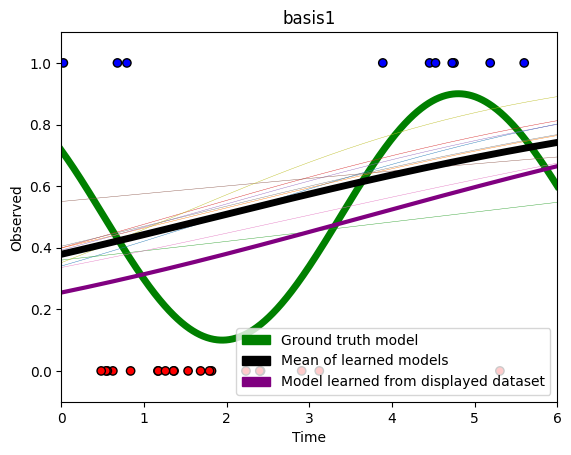

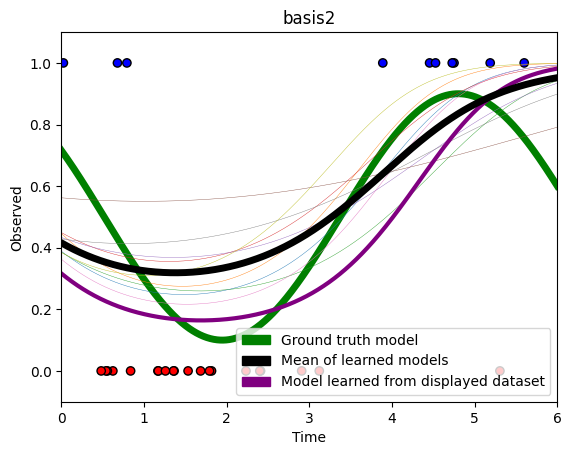

0.1: first model probability: [0.51983634]
0.1: variance: 0.003355342451876528
3.2: first model probability: [1.05019773e-10]
3.2: variance: 0.23999997685725333


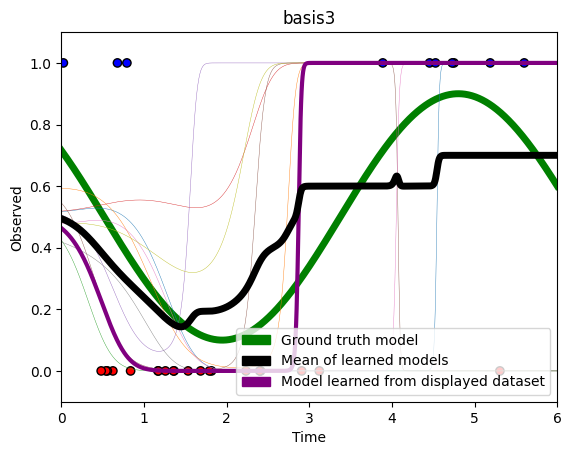

In [111]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [130]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance
        
    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        n, k = 2, 3
        self.mu = np.zeros((k, n))
        if self.is_shared_covariance:
            self.cov = np.zeros((n, n))
        else:
            self.cov = np.zeros((k, n, n))
        self.priors = np.zeros(k)
        for cls in range(k):
            X_class = X[y == cls]
            if self.is_shared_covariance:
                self.cov += np.cov(X_class, rowvar = False) * (X_class.shape[0] - 1)
            else:
                self.cov[cls] = np.cov(X_class, rowvar = False)
            
            self.priors[cls] = X_class.shape[0] / X.shape[0]
            self.mu[cls] = np.mean(X_class, axis = 0)

        if self.is_shared_covariance:
            self.cov /= (X.shape[0] - k)
        return None

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        sample_size = X_pred.shape[0]
        probs = np.zeros((sample_size, 3))
        for cls in range(3):
            if self.is_shared_covariance:
                # shared covariance
                d = mvn(mean = self.mu[cls], cov = self.cov)
            else:
                # class-specific covariance
                d = mvn(mean = self.mu[cls], cov = self.cov[cls])
            probs[:, cls] = d.pdf(X_pred) * self.priors[cls]
        return np.argmax(probs, axis = 1)

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to 
        calculate the negative log likelihood of the data
        """
        neg_log_likelihood = 0
        for cls in range(3):
            X_class = X[y == cls]
            cov = None
            if self.is_shared_covariance:
                # shared covariance
                cov = self.cov
            else:
                # class specific covvariance
                cov = self.cov[cls]
            log_pdf = mvn(X_class, mean = self.mu[cls], cov = cov)
            neg_log_likelihood -= log_pdf.sum()
        return neg_log_likelihood
    
    def gaussian_log_probs(self, X):
        if self.is_shared_covariance:
            cov = self.covariance
        log_probs = np.array([mvn.logpdf(X, mean=mu, cov=self.covariance if self.is_shared_covariance else self.covariances[k])
                              for k, mu in enumerate(self.means)])
        return log_probs

    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        log_probs = self.gaussian_log_probs(X_pred)
        probs = np.exp(log_probs.T + self.prior)
        probs /= probs.sum(axis=0, keepdims=True)
        return probs

In [113]:
print(X_stars)
print(X_stars.shape[1])
print(y_stars)


[[-5.8  -0.35]
 [-4.1  -0.31]
 [-1.1  -0.16]
 [ 0.7   0.  ]
 [ 2.    0.13]
 [ 2.6   0.27]
 [ 3.4   0.42]
 [ 4.4   0.58]
 [ 5.1   0.7 ]
 [ 5.9   0.89]
 [ 7.3   1.18]
 [ 9.    1.45]
 [11.8   1.63]
 [ 1.1   0.65]
 [ 0.7   0.85]
 [ 0.5   1.07]
 [-0.2   1.41]
 [-0.4   1.6 ]
 [-0.8   1.85]
 [-6.4  -0.25]
 [-6.2   0.  ]
 [-6.    0.25]
 [-6.    0.7 ]
 [-6.    1.06]
 [-5.    1.39]
 [-5.    1.7 ]
 [-5.    1.94]]
2
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2]


In [114]:
class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        
        bias = np.ones((len(X), 1))
        X = np.hstack((bias, X))
        num_c = 1 + y.max()
        num_f = X.shape[1]
        self.W = np.ones((num_c, num_f))
        
        one_hot_y = np.eye(num_c)[y]

        for _ in range(200000):
            y_pred = softmax(np.dot(self.W, X.T), axis=0)
            gradient = np.dot(y_pred - one_hot_y.T, X) + self.lam * self.W
            self.W -= self.eta * gradient
        pass

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        y_probs = self.predict_proba(X_pred)
        return np.argmax(y_probs, axis=1)
    
    
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        bias = np.ones((X_pred.shape[0], 1))
        X_pred = np.hstack((bias, X_pred))
        z = np.dot(X_pred, self.W.T)
        return softmax(z, axis=1)

In [115]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k
        
    def distance(self, star1, star2):
        return ((star1[0] - star2[0])**2) / 9 + (star1[1] - star2[1])**2
        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        predictions = []
        for test_point in X_pred:
            distances = np.array([self.distance(test_point, star) for star in self.X])
            nearest_neighbors_indices = np.argsort(distances)[:self.K]
            nearest_labels = self.y[nearest_neighbors_indices]
            label_counts = Counter(nearest_labels)
            most_common_label = label_counts.most_common(1)[0][0]
            predictions.append(most_common_label)
        return np.array(predictions)

In [116]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    res = np.zeros(X.shape)
    res[:, 0] = np.log(X[:, 0] + 10)
    res[:, 1] = np.square(X[:, 1])
    return res

## Plotting Function for Problem 3, Subpart 1

In [117]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

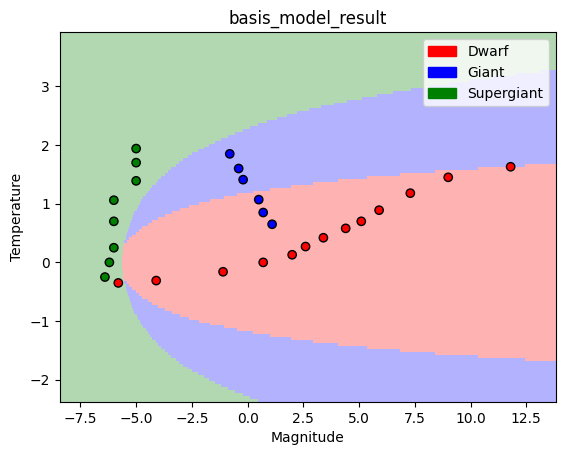

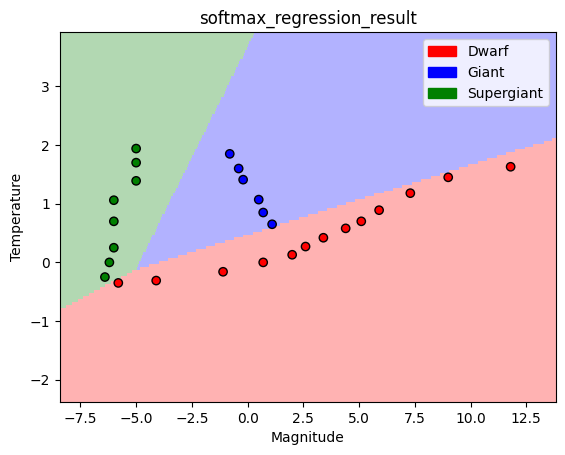

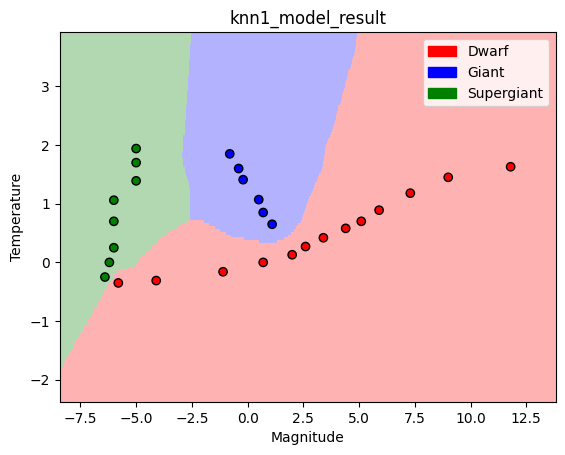

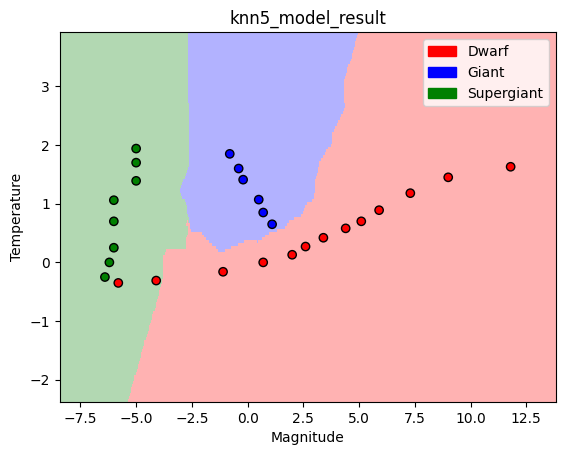

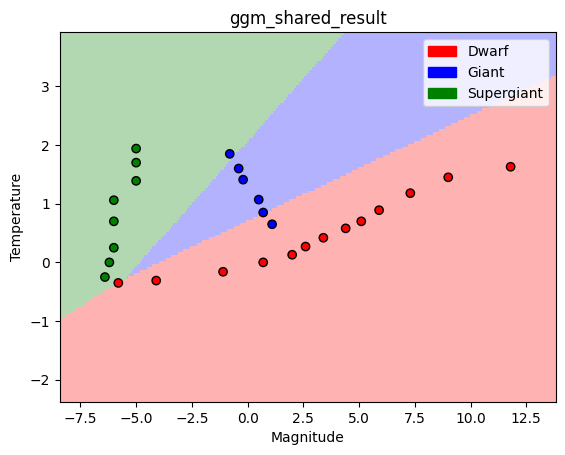

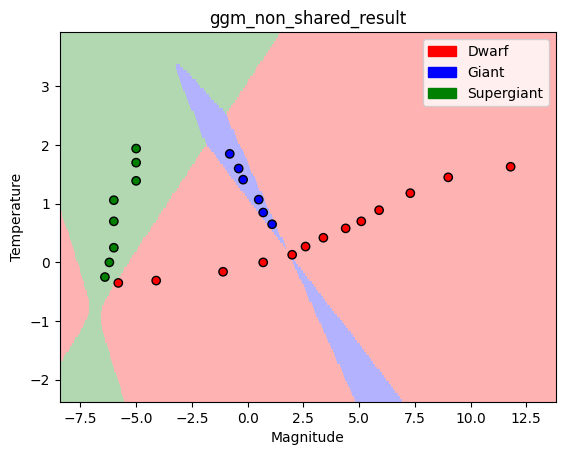

In [131]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='basis_model_result',
                   basis=phi)

softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

knn1_model = KNNClassifier(k=1)
knn1_model.fit(X_stars, y_stars)
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn1_model_result',
                   basis=None)

knn5_model = KNNClassifier(k=5)
knn5_model.fit(X_stars, y_stars)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn5_model_result',
                   basis=None)

ggm_shared = GaussianGenerativeModel(is_shared_covariance=True)
ggm_shared.fit(X_stars, y_stars)
visualize_boundary(model=ggm_shared,
                   X=X_stars,
                   y=y_stars,
                   title='ggm_shared_result',
                   basis=None)

ggm_non_shared = GaussianGenerativeModel(is_shared_covariance=False)
ggm_non_shared.fit(X_stars, y_stars)
visualize_boundary(model=ggm_non_shared,
                   X=X_stars,
                   y=y_stars,
                   title='ggm_non_shared_result',
                   basis=None)

In [119]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

Passed softmax regression tests
Passed KNN tests


In [132]:
x = np.array([3, -2]).reshape(1, -1)


basis_model_prob = basis_model.predict_proba(x)

softmax_model_prob = softmax_model.predict_proba(x)

ggm_shared_prob = ggm_shared.predict_proba(x)

ggm_non_shared_prob = ggm_non_shared.predict_proba(x)

knn1_predict = knn1_model.predict(x)

knn5_predict = knn5_model.predict(x)

print(f'probabilities for basis model: {basis_model_prob}')
print(f'probabilities for softamx model: {softmax_model_prob}')
print(f'probabilities for ggm shared cov model: {ggm_shared_prob}')
print(f'probabilities for ggm not shared cov model: {ggm_non_shared_prob}')

knn1_predict, knn5_predict

probabilities for basis model: [[9.99074167e-01 9.25832507e-04 1.60413109e-15]]
probabilities for softamx model: [[1.00000000e+00 1.31778926e-28 2.56768493e-40]]
probabilities for ggm shared cov model: [9.99999978e-01 2.24128033e-08 1.88576308e-12]
probabilities for ggm not shared cov model: [1. 0. 0.]


(array([0]), array([0]))